In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score

from pygraphs.cluster import KernelKMeans, Ward, KernelKMeansSklearn, KernelWardSklearn
from pygraphs.graphs.generators import StochasticBlockModel2, RubanovModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE, scaler
from pygraphs.scenario import ParallelByGraphs, RejectCurve, plot_results, d3_right_order
from pygraphs.colors import d3_category20

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# 1.
Привлекает внимание Heat (p.4). Частично мы это уже обсуждали. Самое невероятное - что при p_out = 0.1 для абсолютного большинства графов Heat разделяет классы лучше, чем при p_out = 0.05. Т.е. при 0.05 просто нет графов, кот. разделяются так же хорошо, как большинство при 0.1. Как это возможно? Или лучшие графы при 0.05 дают переполнение и отбрасываются?
При p_out = 0.1 есть буквально 5 патологических графов. Что с ними происходит, почему Heat не справляется? Можно было бы предположить, что это графы, где плотность межклассовых связей существенно отклоняется вверх от 0.1.

In [3]:
rc = RejectCurve([100], [2], [0.3], [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], [Heat_H], [Heat], StochasticBlockModel2, Ward)

In [18]:
results_params = rc.calc(4, -1)

calc data to find best params...



find best params...
(100, 2, 0.3, 0.05)	Heat H  	0.34 (1.00)
(100, 2, 0.3, 0.1)	Heat H  	0.72 (0.68)
(100, 2, 0.3, 0.15)	Heat H  	0.84 (0.18)
(100, 2, 0.3, 0.2)	Heat H  	0.98 (0.10)
(100, 2, 0.3, 0.25)	Heat H  	0.88 (0.01)
(100, 2, 0.3, 0.3)	Heat H  	0.98 (0.01)


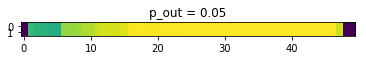

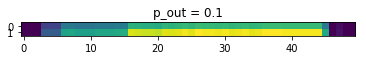

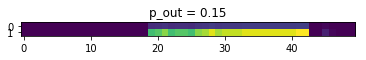

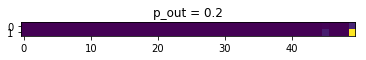

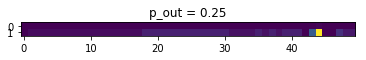

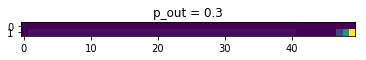

In [27]:
for p_out in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    x, y, error = results_params[(100, 2, 0.3, p_out)]['Heat H']
    plt.imshow([y, y/np.max(y)], vmin=0, vmax=1)
    plt.title("p_out = {}".format(p_out))
    plt.show()

In [7]:
results_rc = rc.perform(100)

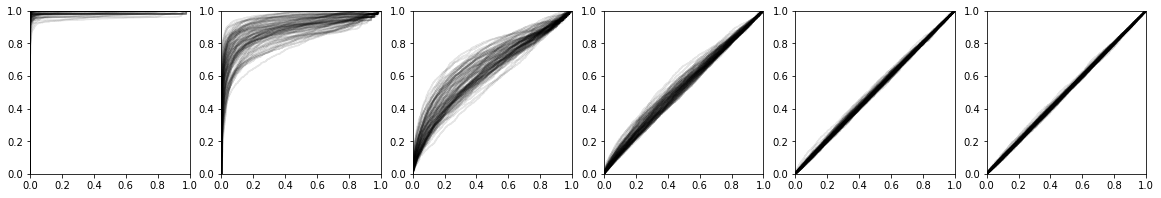

In [8]:
fig, ax = plt.subplots(1, 6, figsize=(20, 3))
for idx, column in enumerate([(100, 2, 0.3, 0.05), (100, 2, 0.3, 0.1), (100, 2, 0.3, 0.15), (100, 2, 0.3, 0.2), (100, 2, 0.3, 0.25), (100, 2, 0.3, 0.3)]):
    for tpr, fpr in results_rc[column]['Heat']:
        ax[idx].plot(tpr, fpr, color='black', alpha=0.1)
        ax[idx].set_xlim(0, 1)
        ax[idx].set_ylim(0, 1)

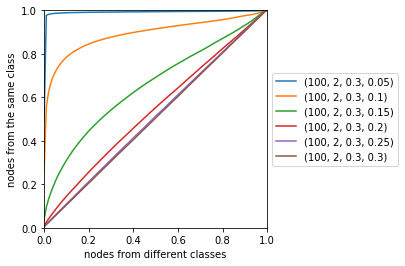

In [9]:
d3c = (x for x in d3_category20[::2])

fig, axi = plt.subplots(1, figsize=(5, 4))
for idx, column in enumerate([(100, 2, 0.3, 0.05), (100, 2, 0.3, 0.1), (100, 2, 0.3, 0.15), (100, 2, 0.3, 0.2), (100, 2, 0.3, 0.25), (100, 2, 0.3, 0.3)]):
    tpr_all = defaultdict(list)
    for tpr, fpr in results_rc[column]['Heat']:
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[np.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=column, color=d3c.__next__())

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");